In [4]:
!pip install rouge-score
!pip install rouge
!pip install pyspellchecker
!pip install bert-score
!pip install sentence-transformers

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import random
import spacy
import string
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from collections import Counter
import math
from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D,Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


import seaborn as sns #Understanding my variables
import matplotlib.pyplot as plt
%matplotlib inline

from spellchecker import SpellChecker

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#TRADE EACH OF THE TRAINING_TASK_C CSVs FOR DIFFERENT CLASS TWEET GENERATION

full_data = pd.read_csv("training_task_c_comments.csv")

In [4]:
full_data.shape

(2907, 2)

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2907 entries, 0 to 2906
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   parent_tweet  2907 non-null   object
 1   reply_tweet   2907 non-null   object
dtypes: object(2)
memory usage: 45.5+ KB


In [6]:
full_data.head()

,parent_tweet,reply_tweet
0,#4U9525 From FL380 to FL110 in 8 min? That's a...,@RAeSTimR @thatjohn Ahh.. I was always taught ...
1,#4U9525 From FL380 to FL110 in 8 min? That's a...,@AirSmolik Only entered FL380 for a few mins p...
2,#4U9525 From FL380 to FL110 in 8 min? That's a...,@AirSmolik but at a controlled speed (unless r...
3,#4U9525 From FL380 to FL110 in 8 min? That's a...,@AirSmolik descent rate is not that unusual.
4,#4U9525 From FL380 to FL110 in 8 min? That's a...,@AirSmolik pilots may have been suffering a Hy...


# Data Cleaning And Preprocessing

In [7]:
full_data["reply_tweet"] = full_data.apply(lambda row: re.sub("\B#\w+", "", row['reply_tweet']), axis=1)
full_data["reply_tweet"] = full_data.apply(lambda row: re.sub("\B@\w+", "", row['reply_tweet']), axis=1)

In [8]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
stop_words = set(stopwords.words('english'))
spell = SpellChecker()
def cleanText(text):
    text = str(text).lower()
    text = re.sub("\B#\w+", "", text)
    text = re.sub("\B@\w+", "", text)
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        corrected_text.append(word)
        text = " ".join(corrected_text)
        text = " ".join([word for word in str(text).split() if word not in stop_words])
    text.translate(str.maketrans('', '', string.punctuation))
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [9]:
full_data["parent_tweet"] = full_data["parent_tweet"].apply(cleanText)

In [10]:
full_data.head()

,parent_tweet,reply_tweet
0,fl380 fl110 8 min? that's average rate descent...,Ahh.. I was always taught it was a UK only t...
1,fl380 fl110 8 min? that's average rate descent...,Only entered FL380 for a few mins prior too. ...
2,fl380 fl110 8 min? that's average rate descent...,but at a controlled speed (unless readings we...
3,fl380 fl110 8 min? that's average rate descent...,descent rate is not that unusual.
4,fl380 fl110 8 min? that's average rate descent...,pilots may have been suffering a Hypoxie


# Preparing Input for the Encoder

In [11]:
parent_tweet = list()
for line in full_data['parent_tweet']:
  parent_tweet.append(line)

tokenizer = Tokenizer()
tokenizer.fit_on_texts( parent_tweet ) 
tokenized_parent = tokenizer.texts_to_sequences( parent_tweet ) 

length_list = list()
for token_seq in tokenized_parent:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Input max length is {}'.format( max_input_length ))

padded_parent_lines = sequence.pad_sequences( tokenized_parent , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_parent_lines )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

input_word_dict = tokenizer.word_index
num_input_tokens = len( input_word_dict )+1
print( 'Number of Input tokens = {}'.format( num_input_tokens))

Input max length is 21
Encoder input data shape -> (2907, 21)
Number of Input tokens = 3336


# Preparing Input for Decoder

In [12]:
reply_tweet = list()
for line in full_data['reply_tweet']:
  reply_tweet.append( '<START> ' + line + ' <END>' )  

tokenizer = Tokenizer()
tokenizer.fit_on_texts( reply_tweet ) 
tokenized_reply = tokenizer.texts_to_sequences( reply_tweet ) 

length_list = list()
for token_seq in tokenized_reply:
    length_list.append( len( token_seq ))
max_output_length = np.array( length_list ).max()
print( 'Output max length is {}'.format( max_output_length ))

padded_reply_lines = sequence.pad_sequences( tokenized_reply , maxlen=max_output_length , padding='post' )
decoder_input_data = np.array( padded_reply_lines )
print( 'Encoder Output data shape -> {}'.format( decoder_input_data.shape ))

output_word_dict = tokenizer.word_index
num_output_tokens = len( output_word_dict )+1
print( 'Number of Output tokens = {}'.format( num_output_tokens))

Output max length is 30
Encoder Output data shape -> (2907, 30)
Number of Output tokens = 5771


# Preparing Output for the Decoder

In [13]:
decoder_target_data = list()
for token_seq in tokenized_reply:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_reply_lines = sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_output_lines = np_utils.to_categorical( padded_reply_lines , num_output_tokens )
decoder_target_data = np.array( onehot_output_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))

Decoder target data shape -> (2907, 30, 5771)


# Defining the Model

In [14]:
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( num_input_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( num_output_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( num_output_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    854016      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1477376     ['input_2[0][0]']                
                                                                                              

# Training

In [15]:
model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=512, epochs=200) 
model.save( 'model.h5' ) 

Epoch 1/200
6/6 [==============================] - 13s 433ms/step - loss: 4.1181
Epoch 2/200
6/6 [==============================] - 3s 422ms/step - loss: 4.0266
Epoch 3/200
6/6 [==============================] - 3s 422ms/step - loss: 3.4715
Epoch 4/200
6/6 [==============================] - 3s 415ms/step - loss: 3.1155
Epoch 5/200
6/6 [==============================] - 3s 415ms/step - loss: 3.1132
Epoch 6/200
6/6 [==============================] - 2s 406ms/step - loss: 3.0691
Epoch 7/200
6/6 [==============================] - 2s 414ms/step - loss: 3.0559
Epoch 8/200
6/6 [==============================] - 3s 424ms/step - loss: 3.0383
Epoch 9/200
6/6 [==============================] - 3s 416ms/step - loss: 3.0275
Epoch 10/200
6/6 [==============================] - 3s 418ms/step - loss: 3.0178
Epoch 11/200
6/6 [==============================] - 2s 416ms/step - loss: 3.0087
Epoch 12/200
6/6 [==============================] - 3s 422ms/step - loss: 2.9994
Epoch 13/200
6/6 [==================

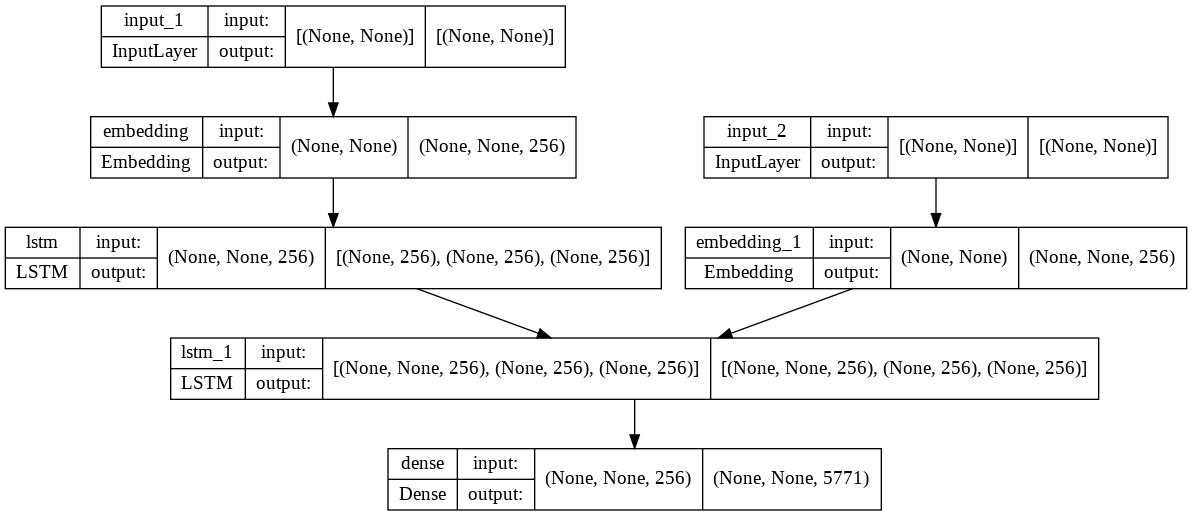

In [16]:
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

# Inference Models

In [1]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=(256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(256,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [2]:
def str_to_tokens( sentence : str ):
    sentence = cleanText(sentence)
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( input_word_dict[ word ] )

    return sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

In [3]:
enc_model , dec_model = make_inference_models()

enc_model.save( 'enc_model.h5' ) 
dec_model.save( 'dec_model.h5' ) 
model.save( 'model.h5' ) 

support_tweet = 'Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/yNlWbNJmYI'
deny_tweet = 'We understand there are two gunmen and up to a dozen hostages inside the cafe under siege at Sydney ISIS flags remain on display #7News'
query_tweet = 'Uber Sydney trips from CBD will be free for riders. Higher rates are still in place to encourage drivers to get into the CBD.'
comment_tweet = '#CharlieHebdo killers shot dead by police'


for epoch in range( encoder_input_data.shape[0] ):
    states_values = enc_model.predict( str_to_tokens(comment_tweet))
    print('\n\nPARENT TWEET: ', comment_tweet)
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = output_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in output_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( "Bot:" +decoded_translation.replace(' end', '') )
    print()
    break

NameError: ignored

#Scores

In [20]:
#BLEU SCORE

from nltk.translate.bleu_score import sentence_bleu

reference_comment = ['YOU LEFT OUT INTERNATIONAL!'.split(),'Great news! 😄'.split(), 
             'best news for days. Goodbye scumbags.'.split(), 
             'they got what they wanted :( but perhaps for the best'.split(), 
             'rot in hell.....', 'hurrah, hell awaits 👹👺'.split(), 
             'No confirmation yet, but hopefully good news'.split(), 
             'best News possible all things considered'.split(), 
             'Good - 2 less to worry about. Hope the Hostages are all OK!'.split(), 
             'great work gsg9 and s/ forces teams.'.split(), 
             'Thinking of the hostages. To hell with the terrorists, they should burn on the street, absolute scum.'.split(), 
             'Good News at last Evil Pigs !!!!'.split(), 
             'Just practice for what coming Im afraid Europe is heading for a war'.split(), 
             'great news'.split(), 'great news great reporting Kay one of the best in the business'.split()]

reference_support = ['Remarkably, despite the military-style police presence in #Ferguson, a known killer was able to skip town http://t.co/lDGjp6Wt1j'.split(), 
                     'â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/0RVUOUMD4zâ€'.split(),
                     'RT @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/MBqXY968OZ'.split(),
                     'RT @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/Q46HFawSF1â€'.split(),
                     'RT @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/OzznStuYOu'.split(),
                     'â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/Gc5H6ZWyNbâ€ ðŸ’”'.split(),
                     'â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/VgscO5lmnwâ€ @CLawtown @pruesiemsgluess'.split(),
                     'RT @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/5gDF9zIXEW'.split(),
                     'â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/bHsin3DQ07â€ Oh Jeez, no!!!'.split(),
                     'RT: @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/7XowawsXF7'.split(),
                     'RT â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/OJeJSNtgwvâ€'.split(),
                     '#BreakingNews â€œ@BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/OYECGiYtfEâ€ #BREAKING #planecrash'.split(),
                     'Yikes :( RT @BBCBreaking: Germanwings Airbus A320 crashes in French Alps near Digne http://t.co/EZ4cgrQxie'.split()]

reference_query = ['@ShirazMaher so what happen to the Charlie hebbdo suspects man news coverage is so shifty in this story'.split(),
                   '@cldaymon @intelwire @ShirazMaher Honestly, we need to wait official statement and investigations. By now, we all talk about rumors.'.split(),
                   '@vanemaya I think we dont have enough facts about the big picture right now (AQAP/ISIS etc), we will need to wait and see  @NickKristof'.split()]

reference_deny = ['@KristyMayr7 @theleadernews not ISIS flags'.split(),
                  '@KristyMayr7 @7NewsAdelaide not ISIS flags. Shahada flags.'.split(),
                  '@KristyMayr7; several of your tweets are either wrong or misleading. Please hold yourself to higher journalism standards!'.split(),
                  '@KristyMayr7  Journalists report facts - reporters bleat out crap they hear. ISIS my arse.'.split(),
                  '@KristyMayr7 Flag in #Sydney hostage situation shows the Islamic profession of faith (shahada). Not an IS flag despite the same wording'.split()]

candidate = decoded_translation.split()

print('Individual 1-gram: %f' % sentence_bleu(reference_comment, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference_comment, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference_comment, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference_comment, candidate, weights=(0, 0, 0, 1)))

score = sentence_bleu(reference_comment, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print('\nBLEU SCORE: %f\n\n' % score)

Individual 1-gram: 0.166667
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000

BLEU SCORE: 0.638943




/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [21]:
# from rouge import Rouge
# ROUGE = Rouge()

# ROUGE.get_scores(reference, candidate)

In [ ]:
#BERT SCORE

from bert_score import BERTScorer

scorer = BERTScorer(lang="en", rescale_with_baseline=True)
P, R, F1 = scorer.score(reference, candidate)

print(F1.mean())

In [ ]:
#BERT SCORE

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = model.encode(reference_comment)
sentence_embeddings.shape

cs = cosine_similarity([sentence_embeddings[0]], sentence_embeddings[1:])
print("BERT SCORE: ",np.mean(cs))

In [ ]:
# #PERPLEXITY


# def bigram_gen(reference):
#     bigrams = []
#     vocab = []
#     for sent in reference:
#       for i in range(len(sent)-1):
#         vocab.append(sent[i])
#         bigrams.append((candidate, sent[i]))
#       vocab.append(sent[-1])
    
#     vocabsize = len(set(vocab))
#     vocab_counts = Counter(vocab)
#     bigram_counts = Counter(bigrams)

# def perplexity(reference, k=0.1):
#     # tokenize and bigramize
    
        
#     # for each bigram, get probability (add-one smoothed)
#     # p(w_i | w_i-1) = count(w_i-1, w_i) + 1 / count(w_i-1 + N)
#     probs = []
#     for bigram in bigrams:
#         b_c = bigram_counts[bigram] + k
#         w_c = vocab_counts[bigram[0]] + k*vocabsize
#         probs.append(b_c/w_c)
    
#     # get inverse
#     inverse = [1.0/prob for prob in probs]
    
#     # get product
#     product = 1.0
#     for inv in inverse:
#         product *= inv
    
#     # n-th root
#     perplexity = math.pow(product, (1/len(reference)))
    
#     return perplexity
  
# # get perplexities
# perplexities = [perplexity(s[1]) for s in reference]
# print(perplexities)